# Cabernet, Anyone? Autopilot Does Text for Wine Reviews
Combining text with tabular data is one place Autopilot really shines. Now, let's learn how to update the classification levels based on our ROC results overnight!

First, please make sure to download the Wine Reviews dataset at the link below. Then, upload onto your notebook in the same directory as this notebook. 
- https://www.kaggle.com/zynicide/wine-reviews

In [ ]:
!apt-get install unzip -y
!unzip 1442_8172_compressed_winemag-data-130k-v2.csv.zip

In [1]:
import pandas as pd

df = pd.read_csv('winemag-data-130k-v2.csv')

# dropping the old index and removing twitter details
df.drop(['Unnamed: 0', 'taster_twitter_handle', 'taster_name'], inplace=True, axis=1)

df.head()

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
import numpy as np

def create_target(df, threshold):
    # looks at the target column, buckets it based on a threshold
    
    df['target'] = np.where(df['points'] >= threshold, 1, 0)
    
    df.drop(['points'], inplace=True, axis=1)
    
    df = df.sample(frac=1)
    
    return df

df = create_target(df, threshold = 89)

df['target'].value_counts()

0    68700
1    61271
Name: target, dtype: int64

In [4]:
# create train and test sets
train_split = 0.85
split_row = round(df.shape[0] * train_split)
train_set = df[:split_row]
test_set = df[split_row:]

# write to disk for autopilot
local_file = 'wine_review_train.csv'
train_set.to_csv(local_file, index=False, header=True)

# write to disk for use later 
test_set.to_csv('test_set.csv', index=False, header=True)

target_attribute_name = 'target'


In [5]:
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from sagemaker import get_execution_role
import sagemaker
import utils as ut

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'wine-reviews-' + timestamp_suffix

role = get_execution_role()

sess = sagemaker.Session()

est_1 = AutoML(role=role,
                target_attribute_name=target_attribute_name,
                base_job_name = base_job_name, 
                sagemaker_session=sess,
                max_candidates=20)

est_1.fit(local_file, job_name=base_job_name, wait=False, logs=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Now, let's run some parallel batch transform jobs to get inference results on all of those models.

In [11]:
import pandas as pd
import utils as ut
import sagemaker

# in case you needed to restart your notebook after Autopilot finished
test_set = pd.read_csv('test_set.csv')

sess = sagemaker.Session()

def get_predictions(job_name, top_n_candidates, test_set):
    
    est, candidates = ut.get_candidates(top_n_candidates, job_name )
    
    test_no_target = test_set.drop('target', axis=1)
    test_file = 'test_without_target.csv'
    test_no_target.to_csv(test_file, index=False, header=False)

    bucket = sess.default_bucket()
    prefix = 'transform'
    input_data_transform = sess.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
    print('Uploaded transform data to {}'.format(input_data_transform))

    transformers = ut.run_transform_jobs(bucket, prefix, est, candidates, input_data_transform)

    # this will wait until the last job is completed
    ut.wait_until_completion(transformers)

    # this copies inference results back from S3 and loads into memory
    predictions = ut.get_predictions(transformers, test_file)
    
    return predictions, candidates

predictions, transformers = get_predictions(job_name = '<paste in your first AutoML job name here>', top_n_candidates = 5, test_set = test_set)

In [6]:
target_attribute_name = 'target'
target_attribute_true_value = 1
labels = test_set[target_attribute_name].apply(lambda row: True if row==target_attribute_true_value else False)

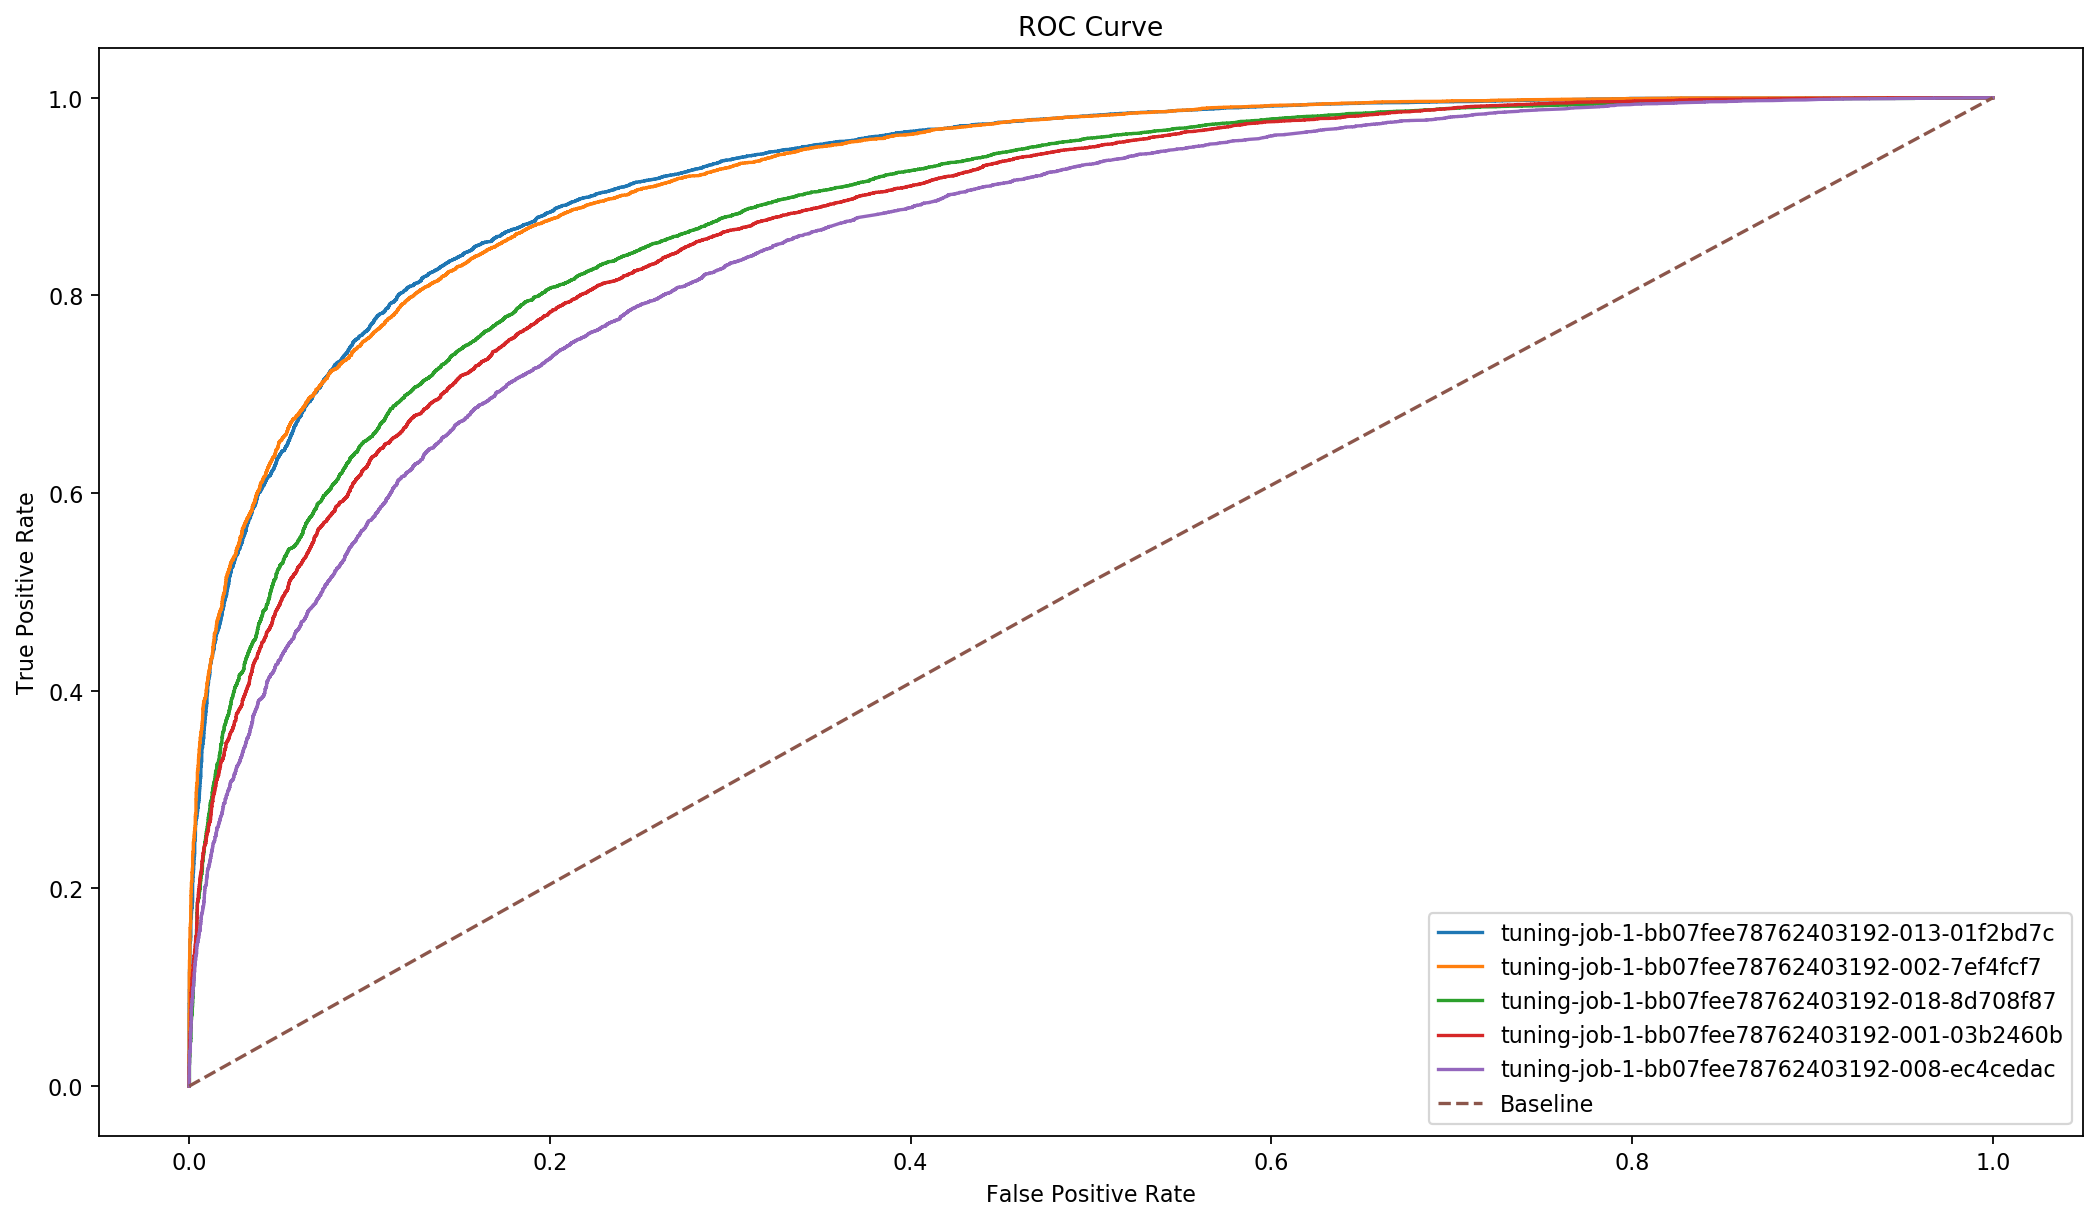

In [7]:
ut.get_roc_curve(predictions, transformers, labels)

In [8]:
ut.get_candidate_for_precision_at_recall(predictions, transformers, labels, target_min_precision = 0.75)

Best Candidate Name: tuning-job-1-bb07fee78762403192-013-01f2bd7c
Best Candidate Threshold (Operation Point): 0.29612407088279724
Best Candidate Recall: 0.9250081512879035


---
## Step Two - Retraining on a Modified Dataset
Now, just after we've deployed our model, our product team tells us they want us to focus on only wines outside of California. They want to test out the model on a different dataset, and believe that we need to produce a model without wines from California. Let's see how to do that, and how it changes our classification levels.

In [3]:
import pandas as pd
import sagemaker
import utils as ut

# pick up the train set in case our kernel halted
train_set = pd.read_csv('wine_review_train.csv')
test_set = pd.read_csv('test_set.csv')

no_cal_train = train_set[ train_set['province'] != 'California']
no_cal_test = test_set[ test_set['province'] != 'California']

local_file = 'no_cal_train.csv'
no_cal_train.to_csv(local_file, index=False, header=True)
no_cal_test.to_csv('no_cal_test.csv', index=False, header=True)

In [10]:
from time import gmtime, strftime, sleep
from sagemaker import get_execution_role
from sagemaker import AutoML

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'wine-reviews-no-cal' + timestamp_suffix

role = get_execution_role()

sess = sagemaker.Session()

est_2 = AutoML(role=role,
                target_attribute_name='target',
                base_job_name = base_job_name, 
                sagemaker_session=sess,
                max_candidates=20)

est_2.fit(local_file, job_name=base_job_name, wait=False, logs=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [12]:
import pandas as pd
import utils as ut
import sagemaker

# in case you needed to restart your notebook after Autopilot finished
no_cal_test = pd.read_csv('no_cal_test.csv')

sess = sagemaker.Session()

def get_predictions(job_name, top_n_candidates, test_set):
    
    est, candidates = ut.get_candidates(top_n_candidates, job_name )
    
    test_no_target = test_set.drop('target', axis=1)
    test_file = 'test_without_target.csv'
    test_no_target.to_csv(test_file, index=False, header=False)

    bucket = sess.default_bucket()
    prefix = 'transform'
    input_data_transform = sess.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
    print('Uploaded transform data to {}'.format(input_data_transform))

    transformers = ut.run_transform_jobs(bucket, prefix, est, candidates, input_data_transform)

    # this will wait until the last job is completed
    ut.wait_until_completion(transformers)

    # this copies inference results back from S3 and loads into memory
    predictions = ut.get_predictions(transformers, test_file)
    
    return predictions, candidates

predictions, candidates = get_predictions(job_name = '<paste your second AutoML job name in here', top_n_candidates = 5, test_set = no_cal_test)

In [9]:
no_cal_labels = no_cal_test['target'].apply(lambda row: True if row==1 else False)

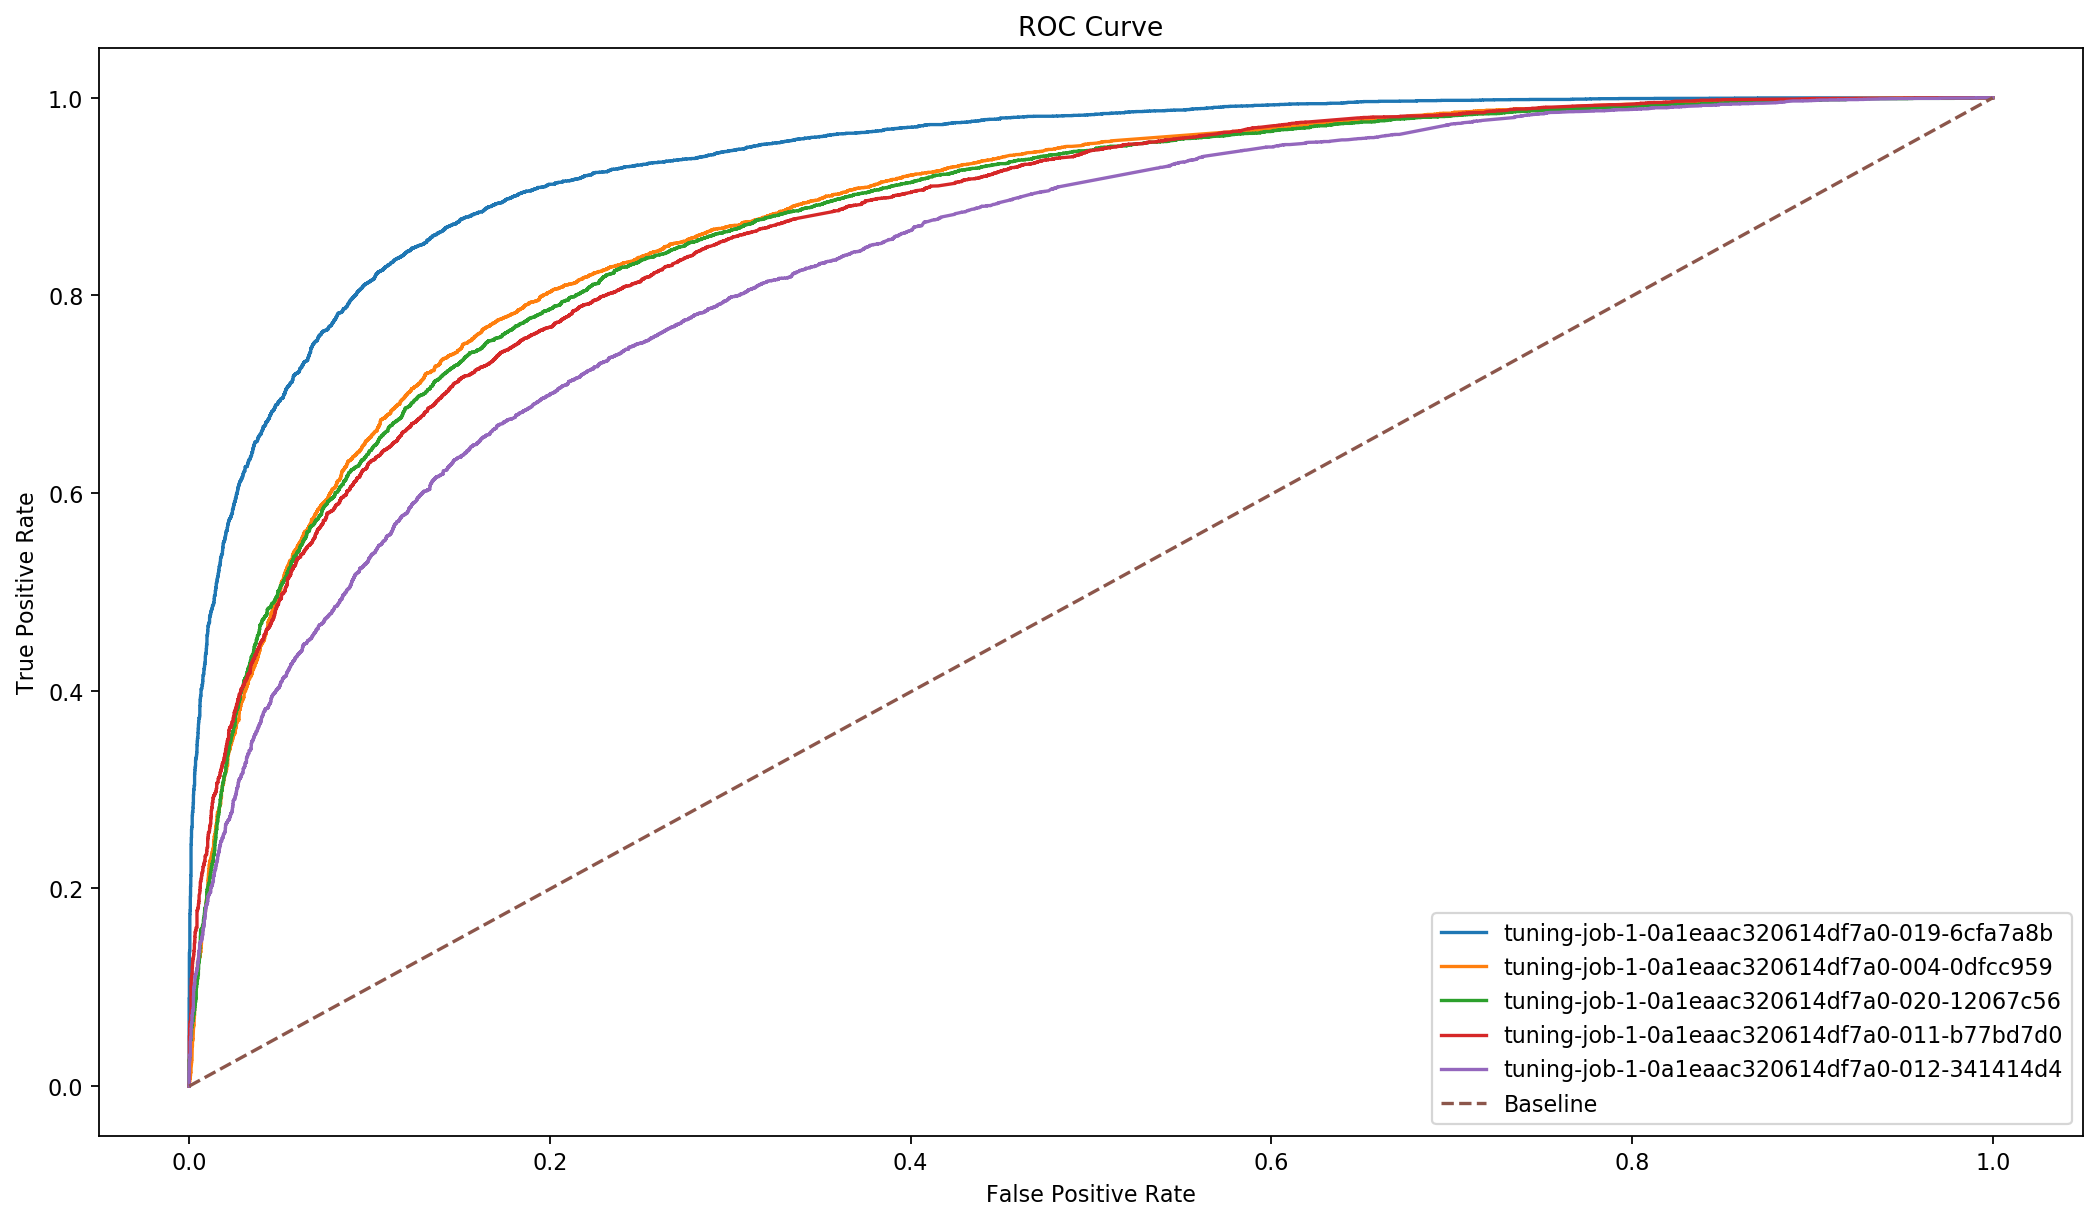

In [10]:
ut.get_roc_curve(predictions, candidates, no_cal_labels)

In [11]:
ut.get_candidate_for_precision_at_recall(predictions, candidates, no_cal_labels, target_min_precision = 0.75)

Best Candidate Name: tuning-job-1-0a1eaac320614df7a0-019-6cfa7a8b
Best Candidate Threshold (Operation Point): 0.2780325710773468
Best Candidate Recall: 0.9367146797425682


---
# Comparison
Now, we see that we trained two models using text in SageMaker Autopilot. The first used the entire dataset, and we found that a classification level of 29% would give us the best performance. Then, after retraining on a modified dataset, we discovered that a new classification level of 17% would make us better off. 